# Compute correlation between eQTL betas and VEP scores for PIP > 0.9 variants

In [2]:
import pandas as pd
import numpy as np
import scanpy as sc
from scipy.stats import pearsonr, mannwhitneyu
from sklearn.metrics import accuracy_score
import anndata
from plotnine import *
import os
from tqdm import tqdm

## Paths

In [3]:
out_dir = '/gstore/data/resbioai/grelu/decima/20240823/bulk_eqtl_results/'
susie_file = os.path.join(out_dir, 'gtex_eqtl_cat_susie_scored.csv')

## Load results

In [4]:
susie = pd.read_csv(susie_file)
print(len(susie))
susie.head(2)

303417


,variant,beta,gene,celltype,abspos_rel_TSS,label,decima_score,borzoi_score,abs_decima_score,abs_borzoi_score
0,chr1_100353172_T_G,-0.261039,CDC14A,adipose_subcutaneous,8170,True,-0.008337,0.003699,0.008337,0.003699
1,chr1_107135646_G_C,1.297660,NTNG1,adipose_subcutaneous,4362,True,0.261189,0.419811,0.261189,0.419811


## Subset to positive (PIP > 0.9) variants only

In [5]:
neg = susie[~susie.label]
susie = susie[susie.label]
len(susie)

10943

In [6]:
tissues = np.sort(susie.celltype.unique())
tissues_w_borzoi = np.sort(susie.dropna(subset='borzoi_score').celltype.unique())
print(len(tissues), len(tissues_w_borzoi))

33 23


## Compute correlations

In [7]:
res = []
for ct in tqdm(tissues):
    # Subset
    susie_ct = susie[susie.celltype==ct].copy()
    n_pos = len(susie_ct)

    # Compute correlations
    decima_pearson = pearsonr(susie_ct.beta, susie_ct.decima_score).statistic
    decima_acc = accuracy_score(susie_ct.beta>0, susie_ct.decima_score>0)
    
    if ct in tissues_w_borzoi:
        borzoi_pearson = pearsonr(susie_ct.beta, susie_ct.borzoi_score).statistic
        borzoi_acc = accuracy_score(susie_ct.beta>0, susie_ct.borzoi_score>0)
    else:
        borzoi_pearson, borzoi_acc = np.nan, np.nan

    res.append((
        ct, n_pos, np.round(decima_pearson, 3), np.round(borzoi_pearson, 3),
        np.round(decima_acc, 3), np.round(borzoi_acc, 3),
    ))

res = pd.DataFrame(res, columns=[
    'tissue', 'n_pos', 'decima_pearson', 'borzoi_pearson', 'decima_acc', 'borzoi_acc'
])

100%|██████████| 33/33 [00:00<00:00, 156.36it/s]


## Visualize

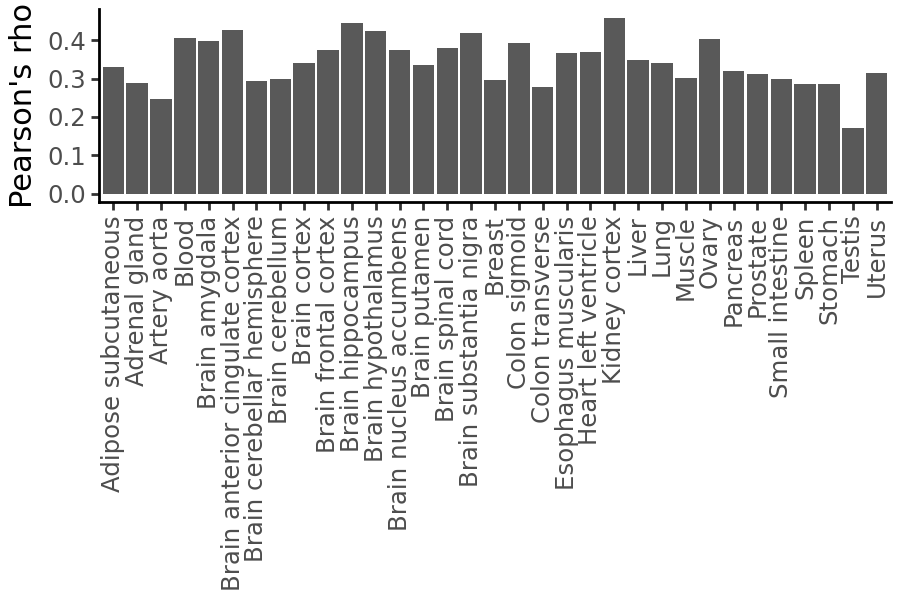

In [16]:
res.tissue = res.tissue.apply( lambda x: x[0].upper() + x[1:].replace('_', ' '))
(
    ggplot(res, aes(x='tissue', y='decima_pearson')) + geom_col() + theme_classic()
    + theme(figure_size=(4.5, 3)) 
    + theme(axis_text_x=element_text(rotation=90, hjust=.5))
    + xlab("") + ylab("Pearson's rho")
)

/home/lala8/.local/share/jupyter/4.0.8/lib/lib/python3.11/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_point : Removed 11 rows containing missing values.


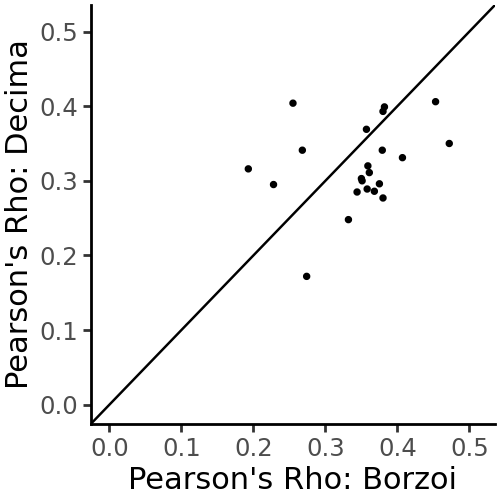

In [71]:
(
    ggplot(res, aes(x='borzoi_pearson', y='decima_pearson')) + geom_point(size=0.5)
    + theme_classic() + theme(figure_size=(2.5, 2.5)) + geom_abline(intercept=0, slope=1)
    + ylim(0, 0.51)
    + xlim(0, 0.51)
    + xlab("Pearson's Rho: Borzoi")
    + ylab("Pearson's Rho: Decima")
)